--- Validating Denoised smfish_cell_model ---


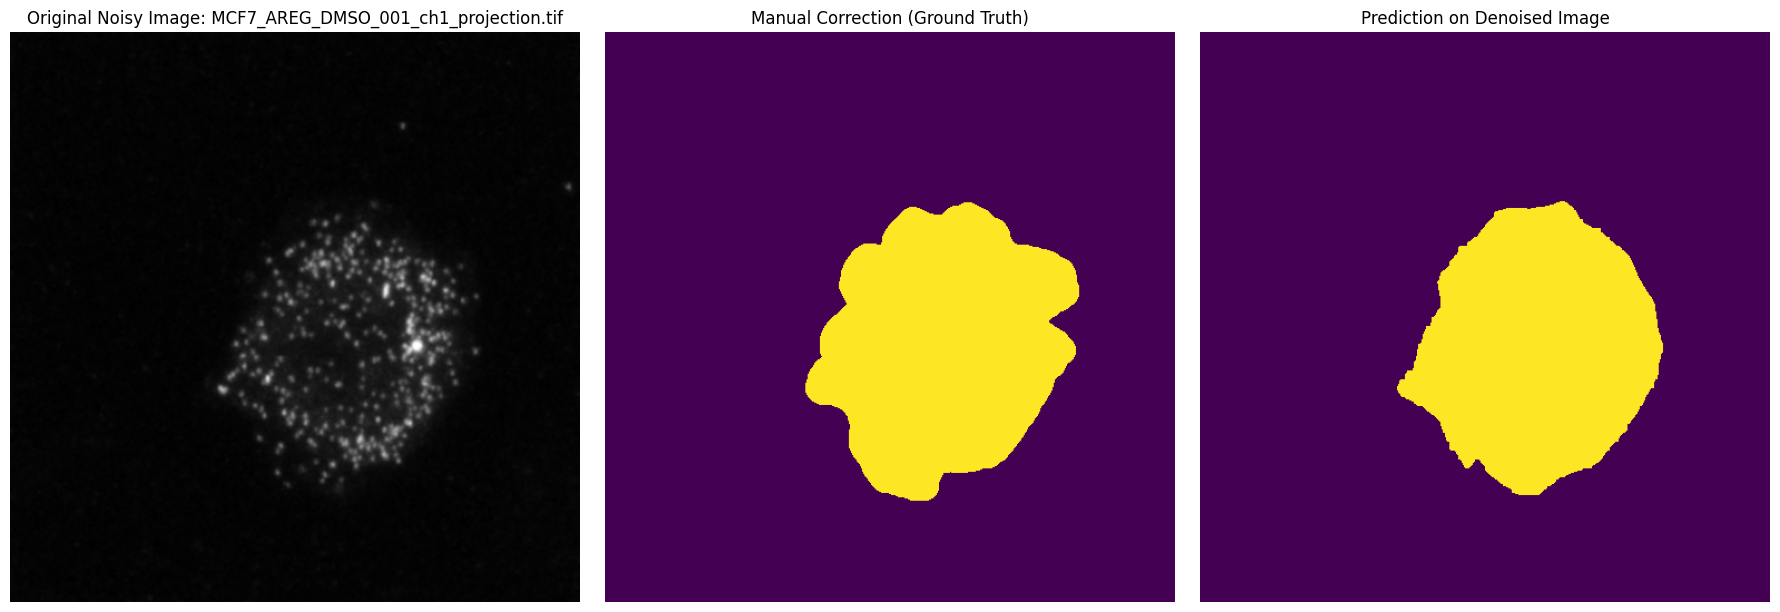

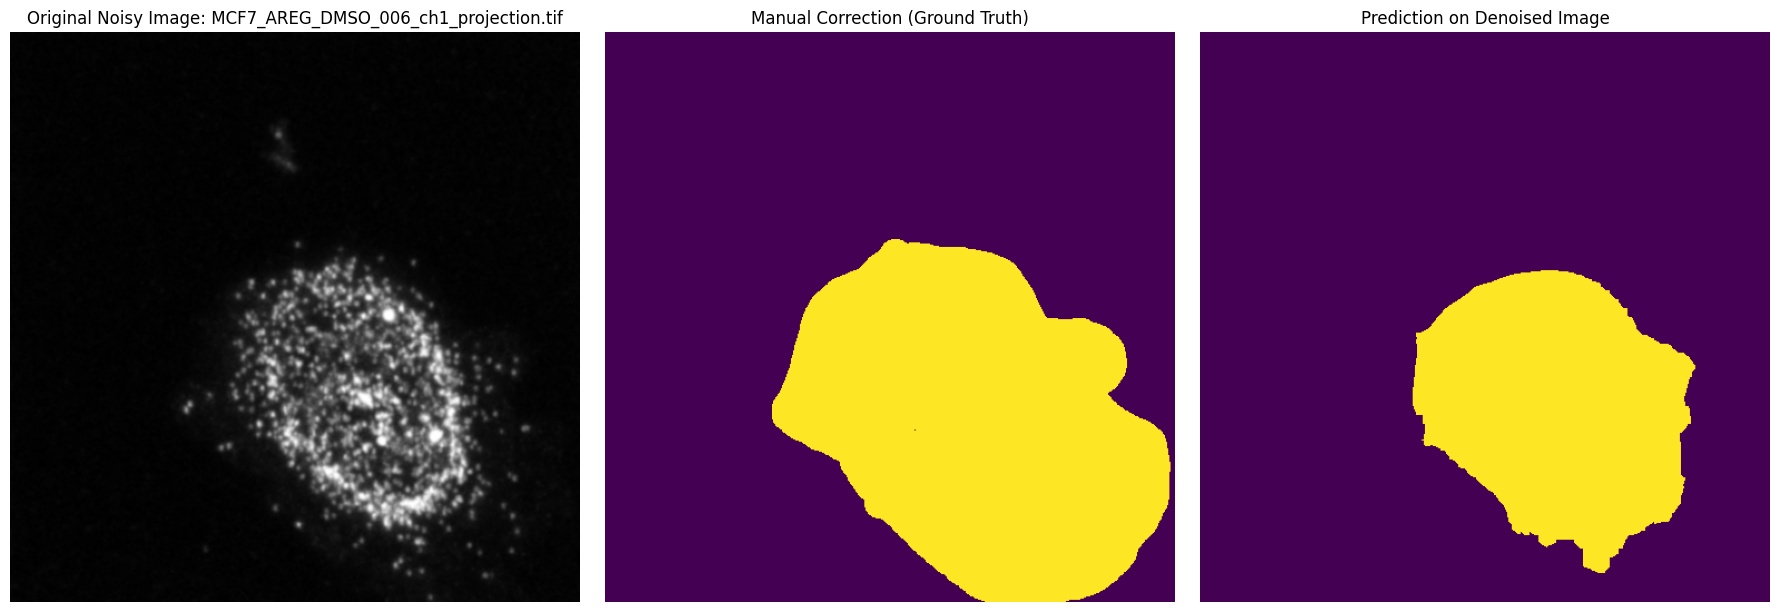

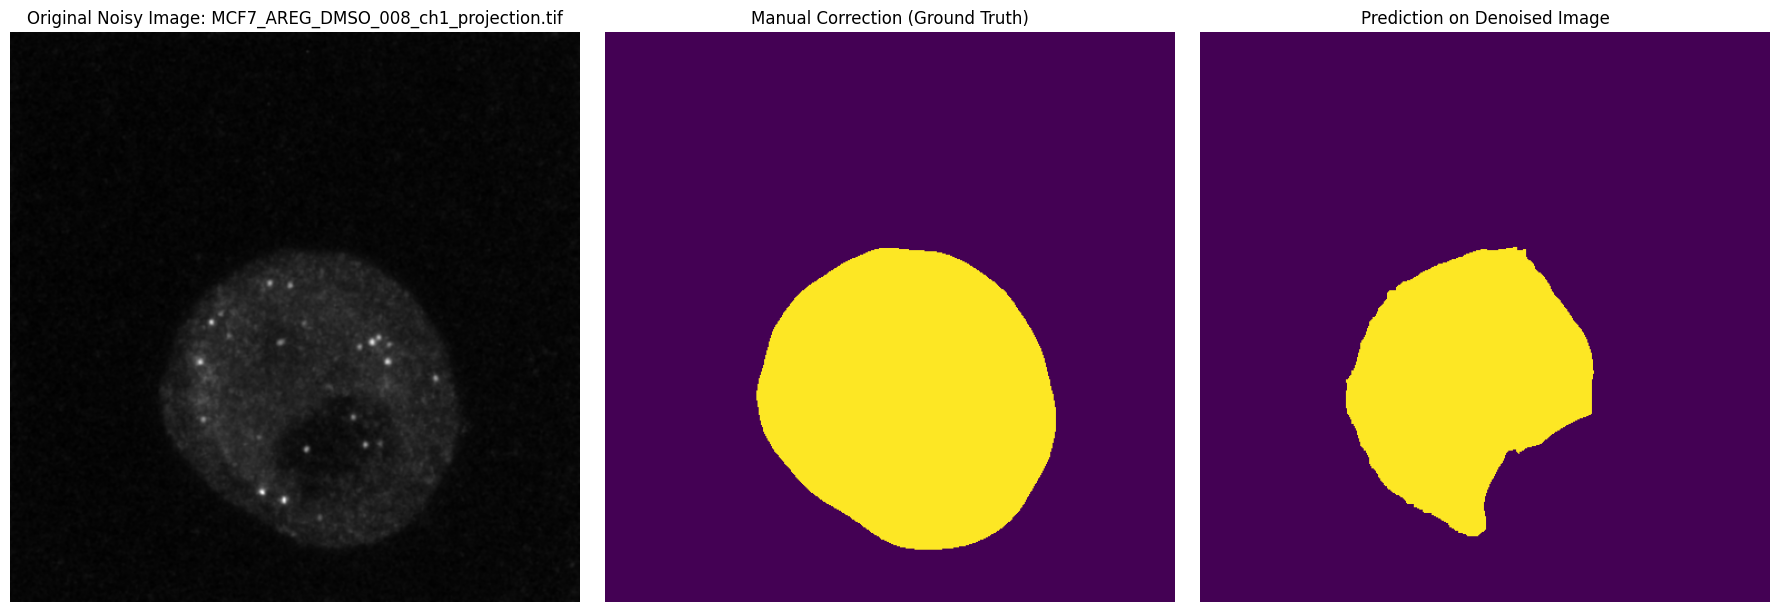

In [4]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import bm3d
from skimage.util import img_as_float
from skimage.restoration import estimate_sigma
from cellpose import models

BASE_DIR = ".."
TRAINING_DIR = os.path.join(BASE_DIR, "data", "training")
MODELS_DIR = os.path.join(BASE_DIR, "models")
CELL_MODEL_PATH = os.path.join(MODELS_DIR, "smfish_cell_model_cpsam")

img_dir = os.path.join(TRAINING_DIR, "images", "fish")
lbl_dir = os.path.join(TRAINING_DIR, "labels", "fish")

image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('_projection.tif')])

DENOISING_STRENGTH_FACTOR = 100.0

if not os.path.exists(CELL_MODEL_PATH):
    print(f"ERROR: Denoised model not found at {CELL_MODEL_PATH}")
else:
    model = models.CellposeModel(gpu=True, pretrained_model=CELL_MODEL_PATH)

    print("--- Validating Denoised smfish_cell_model ---")
    for i in range(min(3, len(image_files))):
        filename = image_files[i]
        
        try:
            original_noisy_img = tifffile.imread(os.path.join(img_dir, filename))
            ground_truth_mask = tifffile.imread(os.path.join(lbl_dir, filename))
            
            noisy_image_float = img_as_float(original_noisy_img)
            noise_sigma_est = np.mean(estimate_sigma(noisy_image_float, channel_axis=None))
            manual_sigma_psd = noise_sigma_est * DENOISING_STRENGTH_FACTOR
            denoised_image = bm3d.bm3d(noisy_image_float, sigma_psd=manual_sigma_psd)
            
            predicted_mask, _, _ = model.eval(denoised_image, diameter=None)
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(original_noisy_img, cmap='gray')
            axes[0].set_title(f"Original Noisy Image: {filename}")
            axes[0].axis('off')

            axes[1].imshow(ground_truth_mask, cmap='viridis')
            axes[1].set_title("Manual Correction (Ground Truth)")
            axes[1].axis('off')

            axes[2].imshow(predicted_mask, cmap='viridis')
            axes[2].set_title("Prediction on Denoised Image")
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"Could not find a matching label for image '{filename}'. Skipping.")
        except Exception as e:
            print(f"An error occurred with {filename}: {e}")